In [4]:
import pandas as pd
import io
import requests
import numpy as np
import collections
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# LSTM

In [5]:
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
dt['Close_y'] = dt['Close']
split = int(0.7 * len(dt))
df_train = dt[:split]
df_test = dt[split:len(dt)]

print("Training set has {} records.".format(len(df_train)))
print("Test set has {} records.".format(len(df_test)))


Training set has 3074 records.
Test set has 1318 records.


Since we want to ensure time-based relationships between observations, we split the data in a sequential way. The first 70% of observations are in the training set, with the remaining in our test.
Additoinally, we create a new column 'Close_y' to preserve the actual observed closing values. This will be used as our dependent variable. This column is needed as the 'Close' column will be used as an input variable and will be normalized.

In [6]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
        
    if sd is None:
        sd = df[name].std()
        
    df[name] = (df[name] - mean) / sd

normal_list = ['Open', 'High', 'Low', 'Volume', 'Close'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Next we normalize the values, and drop the 'date' column from the dataframe. The way we did this caused a warning, however this does not impact our final program.

In [7]:
def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [x for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = df_train['Close_y'][SEQUENCE_SIZE:len(df_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = df_test['Close_y'][SEQUENCE_SIZE:len(df_test)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(obs_train.shape))
print("Shape of y_test: {}".format(obs_test.shape))

Shape of x_train: (3066, 7, 5)
Shape of x_test: (1310, 7, 5)
Shape of y_train: (3066,)
Shape of y_test: (1310,)


Here we transform our data in sequence data. Now, each record is a sequence of 7 days of data, each with 5 relevant pieces of information on that day's market behavior. Additionally, there is one dependent variable for each of these 7x5 structures which holds the close price of the stock on the seventh day.

In [8]:
myDict = dict()
##activationType = ['relu', 'sigmoid', 'tanh']
optimizerType = ['adam', 'sgd']
iteration = 0

for opt in optimizerType:
    ##checkpointer = ModelCheckpoint(filepath="best_weights3.hdf5", verbose=0, save_best_only=True) # save best model        
    ##for i in range(2):
        ##print(i)        
        # Build network
        model = Sequential()
        model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5)))
        model.add(Dense(32))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=opt)        
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
        model.fit(x_train,obs_train,validation_data=(x_test,obs_test), callbacks=[monitor],verbose=2, epochs=100)  


    ##print('Training finished...Loading the best model')  
    ##print()
    ##model.load_weights("best_weights3.hdf5") # load weights from best model
        myDict.update({iteration : (opt, model)})
        iteration += 1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 22s - loss: 125.4652 - val_loss: 2786.7028
Epoch 2/100
3066/3066 - 15s - loss: 4.7794 - val_loss: 2936.8118
Epoch 3/100
3066/3066 - 13s - loss: 2.8729 - val_loss: 2874.0686
Epoch 4/100
3066/3066 - 12s - loss: 2.1659 - val_loss: 3019.0412
Epoch 5/100
3066/3066 - 8s - loss: 1.8381 - val_loss: 3001.2944
Epoch 6/100
3066/3066 - 12s - loss: 1.7135 - val_loss: 2956.8635
Epoch 00006: early stopping
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 11s - loss: 15.3930 - val_loss: 2913.2220
Epoch 2/100
3066/3066 - 9s - loss: 2.7734 - val_loss: 3042.6404
Epoch 3/100
3066/3066 - 11s - loss: 2.3844 - val_loss: 3004.3801
Epoch 4/100
3066/3066 - 11s - loss: 2.1442 - val_loss: 2947.6793
Epoch 5/100
3066/3066 - 13s - loss: 2.2363 - val_l

Here we use checkpointing and earlystopping to iteration through model construction. Checkpointing allows us to save our best model whereas earlystopping will stop training after the model reaches a certain point on the descent algorithm. 

Analyzing model with optimizer adam


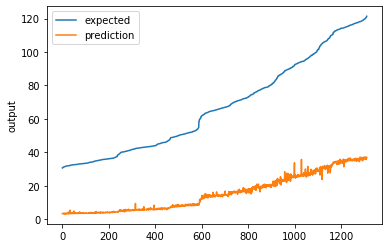

Score (RMSE): 54.37704952187045
Analyzing model with optimizer sgd


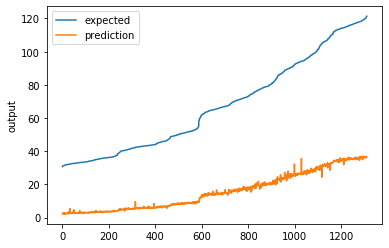

Score (RMSE): 54.34354274385308


In [9]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred.flatten(), 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


for ele in myDict.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

Here we see that both models have a very similar RMSE (implying the optimizer makes little to no difference). Additionally, we see the reression lift chart. We find it a bit odd that there seems to be a relatively consistent linear gap between the expected and the prediction. In other words, it seems odd that our predictions seem to attempt to match the slope of the expected but the y intercept is off by about 20. We assume that this it because we split the data in a linear way

Analyzing model with optimizer adam


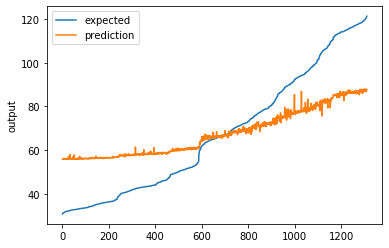

Score (RMSE): 17.394533365517937
Analyzing model with optimizer sgd


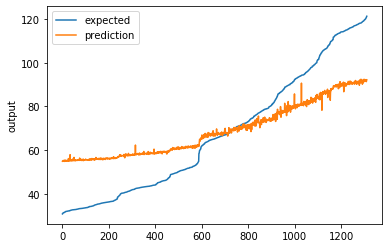

Score (RMSE): 15.879691858016981


In [76]:
for ele in myDict.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    pred = pred + np.mean(obs_test) - np.mean(obs_train)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

We see a slightly improved RMSE, however our curve is too flat. We believe that this is because we have normalized the close price in the input data. We believe this because our model will only be able to notice change in z-scores between close price and use this against an index built on the first 70% of close prices. However, if we included non-normalized close price in our data, we would be able to predict the new close price based on the actual value of the previous close price combined with whatever change value the model predicted. To test our theory, will we model based on non-normalized close price.

In [86]:
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
split = int(0.35 * len(dt))
df_train = dt[:split]
df_train = df_train.append(dt[(len(dt) - split):len(dt)])
df_test = dt[split:(len(dt)-split)]

print(len(df_train))
print(len(df_test))

3074
1318


In [16]:
normal_list = ['Open', 'High', 'Low', 'Volume'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()

SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = df_train['Close'][SEQUENCE_SIZE:len(df_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)
print(obs_train.shape)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = df_test['Close'][SEQUENCE_SIZE:len(df_test)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)
print(obs_test.shape)


(3066,)
(1310,)


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
myDict_mod = dict()
iteration = 0

model = Sequential()
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
model.fit(x_train,obs_train,validation_data=(x_test,obs_test), callbacks=[monitor],verbose=2, epochs=100)  

myDict_mod.update({iteration : (opt, model)})

Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 20s - loss: 1456.3455 - val_loss: 45.1668
Epoch 2/100
3066/3066 - 14s - loss: 180.4926 - val_loss: 230.2672
Epoch 3/100
3066/3066 - 13s - loss: 28.3311 - val_loss: 198.4485
Epoch 4/100
3066/3066 - 13s - loss: 13.7851 - val_loss: 114.5951
Epoch 5/100
3066/3066 - 12s - loss: 10.2722 - val_loss: 112.6094
Epoch 6/100
3066/3066 - 14s - loss: 9.3114 - val_loss: 115.5342
Epoch 00006: early stopping


Analyzing model with optimizer sgd


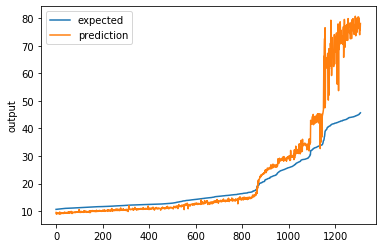

Score (RMSE): 10.748681856320824


In [18]:
for ele in myDict_mod.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

# Fully Connected NN

In [132]:
####################
##Fully Connected NN
####################

####################
##DATA IMPORTING && PREPROCESSING
####################
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
dt['Close_y'] = dt['Close']
split = int(0.7 * len(dt))
df_train = dt[:split]
df_test = dt[split:len(dt)]

print("Training set has {} records.".format(len(df_train)))
print("Test set has {} records.".format(len(df_test)))

close_train = df_train['Close_y']
close_test = df_test['Close_y']

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
        
    if sd is None:
        sd = df[name].std()
        
    df[name] = (df[name] - mean) / sd

normal_list = ['Open', 'High', 'Low', 'Volume', 'Close'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()


def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [x for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = close_train[SEQUENCE_SIZE:len(close_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = close_test[SEQUENCE_SIZE:len(close_test)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)


test_NN = []
for ele in x_test:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    test_NN.append(flat_list)

train_NN = []
for ele in x_train:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    train_NN.append(flat_list)


train_NN = pd.DataFrame(train_NN)
train_NN['out'] = obs_train
test_NN = pd.DataFrame(test_NN)
test_NN['out'] = obs_test


def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


train_NN,y_train2 = to_xy(train_NN, 'out')
test_NN, y_test2 = to_xy(test_NN, 'out')

Training set has 3074 records.
Test set has 1318 records.


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Moving on to the fully connected neural network. We need to do some data wrangling. First off, we need to change the data from 7 day sequence of 5 fields into a 35 field record. Then, we need to do some structure formatting to interface with tensorflow. After doing preprocessing, we are ready for model building.

In [113]:
myDict2 = dict()
activationType = ['relu', 'sigmoid', 'tanh']
optimizerType = ['adam', 'sgd']
iteration = 0

for act in activationType:
    for opt in optimizerType:
        checkpointer2 = ModelCheckpoint(filepath="C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights2.hdf5", verbose=0, save_best_only=True) # save best model
        
        for i in range(1):
            print(i)
            model_NN = Sequential()
            model_NN.add(Dense(35, input_dim=train_NN.shape[1], activation=act))
            model_NN.add(Dense(1))
            model_NN.compile(loss='mean_squared_error', optimizer=opt)        
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
            model_NN.fit(train_NN,y_train2,validation_data=(test_NN,y_test2),callbacks=[monitor, checkpointer2],verbose=2,epochs=100)

        print('Training finished...Loading the best model')  
        print()
        model_NN.load_weights("C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights2.hdf5") # load weights from best model
        myDict2.update({iteration : (act, opt, model_NN)})
        iteration += 1


0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 18s - loss: 210.7895 - val_loss: 4253.5541
Epoch 2/100
3066/3066 - 1s - loss: 65.7728 - val_loss: 3569.4628
Epoch 3/100
3066/3066 - 1s - loss: 44.8690 - val_loss: 3488.7006
Epoch 4/100
3066/3066 - 1s - loss: 42.0661 - val_loss: 3461.2532
Epoch 5/100
3066/3066 - 1s - loss: 38.4576 - val_loss: 3464.0966
Epoch 6/100
3066/3066 - 1s - loss: 33.4760 - val_loss: 3420.4331
Epoch 7/100
3066/3066 - 1s - loss: 27.4198 - val_loss: 3350.0659
Epoch 8/100
3066/3066 - 1s - loss: 21.3884 - val_loss: 3302.3737
Epoch 9/100
3066/3066 - 1s - loss: 15.8614 - val_loss: 3259.4184
Epoch 10/100
3066/3066 - 1s - loss: 11.2376 - val_loss: 3251.6178
Epoch 11/100
3066/3066 - 1s - loss: 7.7733 - val_loss: 3191.5909
Epoch 12/100
3066/3066 - 1s - loss: 5.3417 - val_loss: 3180.6238
Epoch 13/100
3066/3066 - 1s - loss: 3.7676 - val_loss: 3153.6434
Epoch 14/100
3066/3066 - 1s - loss: 2.7655 - val_loss: 3103.3519
Epoch 15/100
3066/3066 - 1s - loss: 2

C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1230: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:995: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/100
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 3/100
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 4/100
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 5/100
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Training finished...Loading the best model

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 18s - loss: 280.3626 - val_loss: 4884.9124
Epoch 2/100
3066/3066 - 1s - loss: 219.8564 - val_loss: 4633.0001
Epoch 3/100
3066/3066 - 1s - loss: 176.9858 - val_loss: 4397.5751
Epoch 4/100
3066/3066 - 1s - loss: 138.9309 - val_loss: 4160.9967
Epoch 5/100
3066/3066 - 1s - loss: 106.4769 - val_loss: 3938.4000
Epoch 6/100
3066/3066 - 1s - loss: 80.5117 - val_loss: 3745.2858
Epoch 7/100
3066/3066 - 1s - loss: 61.8800 - val_loss: 3584.1147
Epoch 8/100
3066/3066 - 1s - loss: 48.6424 - val_loss: 3449.2271
Epoch 9/100
3066/3066 - 1s - loss: 39.2449 - val_loss: 3337.0547
Epoch 10/100
3066/3066 - 1s - loss: 32.3807 - val_loss: 3243.5206
E

Similar to our LTSM, we use early stopping and model checkpointing to iterate (and avoid local optima) and save the weights to reference our best model. However, we are iterating through activation layer types as well as optimerizers. An observation about training these models is that they are much faster than the LTSM (in terms of training time per epoch). However, many more epochs are needed to reache the lost cutoff point.

Analyzing model with activation relu and optimizer adam


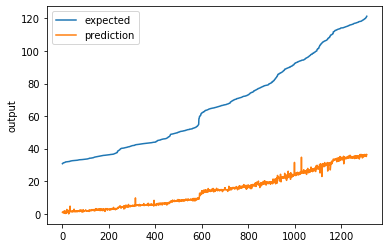

Score (RMSE): 55.163604157686365
Analyzing model with activation relu and optimizer sgd


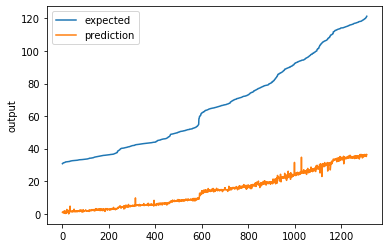

Score (RMSE): 55.163604157686365
Analyzing model with activation sigmoid and optimizer adam


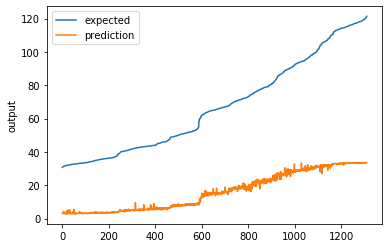

Score (RMSE): 53.891162011847086
Analyzing model with activation sigmoid and optimizer sgd


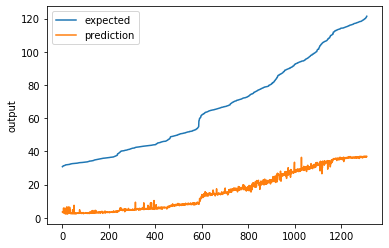

Score (RMSE): 53.63382021022067
Analyzing model with activation tanh and optimizer adam


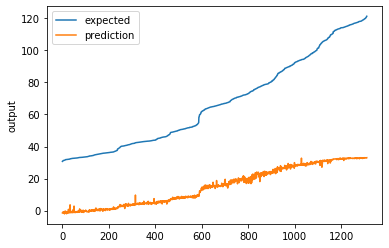

Score (RMSE): 54.521980941405054
Analyzing model with activation tanh and optimizer sgd


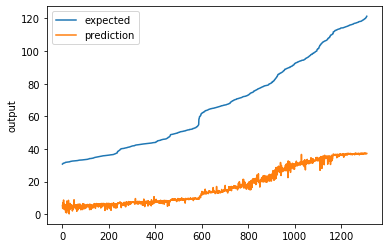

Score (RMSE): 52.67523390970125


In [114]:
for ele in myDict2.values():
    print('Analyzing model with activation {} and optimizer {}'.format(ele[0], ele[1]))
    model_NN = ele[2]
    pred_NN = model_NN.predict(test_NN)
       
    score_NN = np.sqrt(metrics.mean_squared_error(pred_NN,obs_test))
    chart_regression(pred_NN,obs_test)
    print("Score (RMSE): {}".format(score_NN))
    

We see again that our model suffers due to the normalization of the input variable 'Close' we will construct a model this variable in its raw form.

Training set has 3074 records.
Test set has 1318 records.


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 0s - loss: 311.7901 - val_loss: 60.3453
Epoch 2/100
3066/3066 - 0s - loss: 0.9275 - val_loss: 4.7307
Epoch 3/100
3066/3066 - 0s - loss: 0.3115 - val_loss: 4.0971
Epoch 4/100
3066/3066 - 0s - loss: 0.2664 - val_loss: 3.7864
Epoch 5/100
3066/3066 - 0s - loss: 0.2424 - val_loss: 4.0720
Epoch 6/100
3066/3066 - 0s - loss: 0.2299 - val_loss: 3.9568
Epoch 7/100
3066/3066 - 0s - loss: 0.2181 - val_loss: 4.3980
Epoch 8/100
3066/3066 - 0s - loss: 0.2030 - val_loss: 3.3398
Epoch 9/100
3066/3066 - 0s - loss: 0.2007 - val_loss: 4.1940
Epoch 10/100
3066/3066 - 0s - loss: 0.1952 - val_loss: 5.6903
Epoch 11/100
3066/3066 - 0s - loss: 0.1825 - val_loss: 4.3467
Epoch 12/100
3066/3066 - 0s - loss: 0.1800 - val_loss: 4.5870
Epoch 13/100
3066/3066 - 0s - loss: 0.1800 - val_loss: 5.2582
Epoch 00013: early stopping


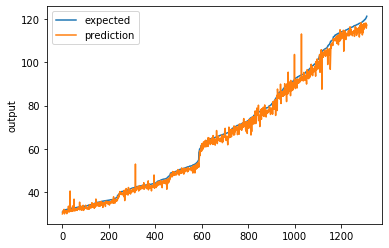

Score (RMSE): 2.2930673465096123


In [13]:
##################
##RAW CLOSE
##################
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
dt['Close_y'] = dt['Close']
split = int(0.7 * len(dt))
df_train = dt[:split]
df_test = dt[split:len(dt)]

print("Training set has {} records.".format(len(df_train)))
print("Test set has {} records.".format(len(df_test)))

close_train = df_train['Close_y']
close_test = df_test['Close_y']

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
        
    if sd is None:
        sd = df[name].std()
        
    df[name] = (df[name] - mean) / sd

normal_list = ['Open', 'High', 'Low', 'Volume'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()


SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = close_train[SEQUENCE_SIZE:len(close_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = close_test[SEQUENCE_SIZE:len(close_test)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)


test_NN = []
for ele in x_test:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    test_NN.append(flat_list)

train_NN = []
for ele in x_train:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    train_NN.append(flat_list)


train_NN = pd.DataFrame(train_NN)
train_NN['out'] = obs_train
test_NN = pd.DataFrame(test_NN)
test_NN['out'] = obs_test


def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


train_NN,y_train2 = to_xy(train_NN, 'out')
test_NN, y_test2 = to_xy(test_NN, 'out')

model_NN = Sequential()
model_NN.add(Dense(35, input_dim=train_NN.shape[1], activation='relu'))
model_NN.add(Dense(1))
model_NN.compile(loss='mean_squared_error', optimizer='adam')        
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
model_NN.fit(train_NN,y_train2,validation_data=(test_NN,y_test2),callbacks=[monitor],verbose=2,epochs=100)

      
pred_NN = model_NN.predict(test_NN)
       
score_NN = np.sqrt(metrics.mean_squared_error(pred_NN,obs_test))
chart_regression(pred_NN,obs_test)
print("Score (RMSE): {}".format(score_NN))

Here we see that our model performs VERY well. It looks like we probably even overfit our data here.

# Extra Features

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train on 3068 samples, validate on 1312 samples
Epoch 1/100
3068/3068 - 13s - loss: 1645.2670 - val_loss: 43.8213
Epoch 2/100
3068/3068 - 12s - loss: 169.6265 - val_loss: 199.6820
Epoch 3/100
3068/3068 - 9s - loss: 20.1758 - val_loss: 152.8646
Epoch 4/100
3068/3068 - 10s - loss: 13.6274 - val_loss: 100.1913
Epoch 5/100
3068/3068 - 13s - loss: 9.7269 - val_loss: 113.3868
Epoch 6/100
3068/3068 - 8s - loss: 9.5433 - val_loss: 84.6688
Epoch 00006: early stopping
Analyzing Model with 5 sequence length


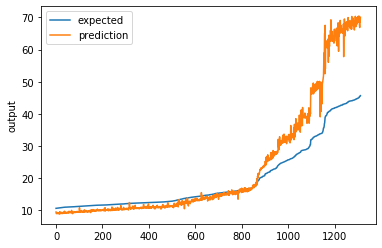

Score (RMSE): 9.201566044631905
Train on 3067 samples, validate on 1311 samples
Epoch 1/100
3067/3067 - 12s - loss: 1475.0237 - val_loss: 34.7854
Epoch 2/100
3067/3067 - 13s - loss: 176.6756 - val_loss: 149.1953
Epoch 3/100
3067/3067 - 14s - loss: 27.1325 - val_loss: 187.7541
Epoch 4/100
3067/3067 - 17s - loss: 15.2068 - val_loss: 142.0997
Epoch 5/100
3067/3067 - 9s - loss: 12.4465 - val_loss: 118.1557
Epoch 6/100
3067/3067 - 15s - loss: 8.5884 - val_loss: 114.7122
Epoch 00006: early stopping
Analyzing Model with 6 sequence length


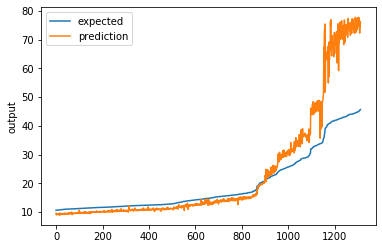

Score (RMSE): 10.710378805237063
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 14s - loss: 1752.1883 - val_loss: 30.9505
Epoch 2/100
3066/3066 - 14s - loss: 248.8911 - val_loss: 170.1665
Epoch 3/100
3066/3066 - 8s - loss: 26.7732 - val_loss: 157.5297
Epoch 4/100
3066/3066 - 10s - loss: 15.6473 - val_loss: 121.5504
Epoch 5/100
3066/3066 - 15s - loss: 13.6528 - val_loss: 133.6730
Epoch 6/100
3066/3066 - 10s - loss: 10.3462 - val_loss: 119.7352
Epoch 00006: early stopping
Analyzing Model with 7 sequence length


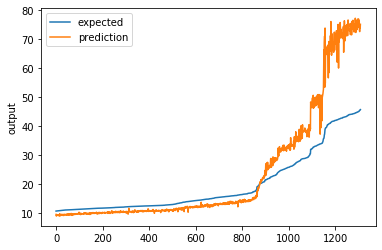

Score (RMSE): 10.942356783908632
Train on 3065 samples, validate on 1309 samples
Epoch 1/100
3065/3065 - 19s - loss: 1765.7038 - val_loss: 69.2660
Epoch 2/100
3065/3065 - 15s - loss: 230.9271 - val_loss: 95.6972
Epoch 3/100
3065/3065 - 11s - loss: 26.9016 - val_loss: 122.4825
Epoch 4/100
3065/3065 - 16s - loss: 12.2599 - val_loss: 83.5534
Epoch 5/100
3065/3065 - 15s - loss: 9.5851 - val_loss: 85.3471
Epoch 6/100
3065/3065 - 17s - loss: 7.5347 - val_loss: 63.0786
Epoch 7/100
3065/3065 - 15s - loss: 6.0835 - val_loss: 62.2233
Epoch 8/100
3065/3065 - 15s - loss: 6.3573 - val_loss: 66.2654
Epoch 9/100
3065/3065 - 16s - loss: 5.2231 - val_loss: 59.5824
Epoch 10/100
3065/3065 - 20s - loss: 4.9870 - val_loss: 57.9099
Epoch 11/100
3065/3065 - 19s - loss: 5.3668 - val_loss: 66.3176
Epoch 12/100
3065/3065 - 17s - loss: 4.3771 - val_loss: 60.7752
Epoch 13/100
3065/3065 - 16s - loss: 4.2710 - val_loss: 50.2291
Epoch 14/100
3065/3065 - 15s - loss: 3.9864 - val_loss: 56.0223
Epoch 15/100
3065/3065 -

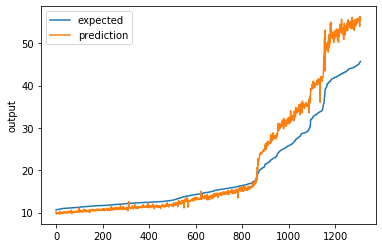

Score (RMSE): 4.597143336786722
Train on 3064 samples, validate on 1308 samples
Epoch 1/100
3064/3064 - 19s - loss: 1481.2196 - val_loss: 85.1838
Epoch 2/100
3064/3064 - 14s - loss: 179.7131 - val_loss: 141.0024
Epoch 3/100
3064/3064 - 16s - loss: 28.8412 - val_loss: 177.8868
Epoch 4/100
3064/3064 - 16s - loss: 15.9905 - val_loss: 169.7795
Epoch 5/100
3064/3064 - 13s - loss: 14.4331 - val_loss: 142.8770
Epoch 6/100
3064/3064 - 9s - loss: 9.3378 - val_loss: 86.3265
Epoch 00006: early stopping
Analyzing Model with 9 sequence length


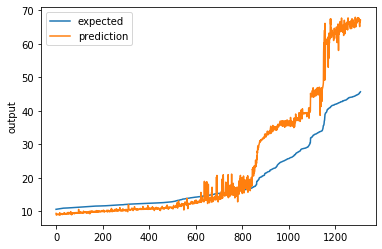

Score (RMSE): 9.291204055259078
Train on 3063 samples, validate on 1307 samples
Epoch 1/100
3063/3063 - 18s - loss: 1669.9573 - val_loss: 69.3738
Epoch 2/100
3063/3063 - 16s - loss: 246.2466 - val_loss: 93.0426
Epoch 3/100
3063/3063 - 16s - loss: 31.9778 - val_loss: 153.2986
Epoch 4/100
3063/3063 - 18s - loss: 18.3884 - val_loss: 89.4388
Epoch 5/100
3063/3063 - 15s - loss: 15.2423 - val_loss: 129.7196
Epoch 6/100
3063/3063 - 13s - loss: 11.1063 - val_loss: 73.5716
Epoch 00006: early stopping
Analyzing Model with 10 sequence length


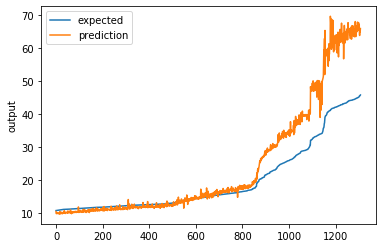

Score (RMSE): 8.577388922582148
Train on 3062 samples, validate on 1306 samples
Epoch 1/100
3062/3062 - 22s - loss: 1533.9729 - val_loss: 52.2577
Epoch 2/100
3062/3062 - 18s - loss: 243.9708 - val_loss: 102.3818
Epoch 3/100
3062/3062 - 21s - loss: 30.8844 - val_loss: 88.6029
Epoch 4/100
3062/3062 - 26s - loss: 14.3268 - val_loss: 102.6058
Epoch 5/100
3062/3062 - 27s - loss: 9.1836 - val_loss: 81.3132
Epoch 6/100
3062/3062 - 20s - loss: 8.2037 - val_loss: 67.3211
Epoch 00006: early stopping
Analyzing Model with 11 sequence length


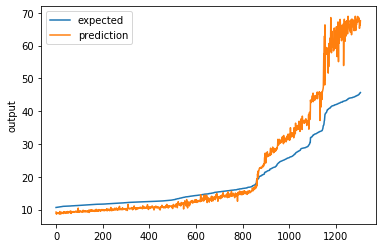

Score (RMSE): 8.204941382400968
Train on 3061 samples, validate on 1305 samples
Epoch 1/100
3061/3061 - 18s - loss: 1518.0603 - val_loss: 24.1045
Epoch 2/100
3061/3061 - 13s - loss: 198.6122 - val_loss: 33.4764
Epoch 3/100
3061/3061 - 18s - loss: 33.0619 - val_loss: 56.7511
Epoch 4/100
3061/3061 - 21s - loss: 14.7824 - val_loss: 85.1050
Epoch 5/100
3061/3061 - 15s - loss: 9.1519 - val_loss: 58.5935
Epoch 6/100
3061/3061 - 17s - loss: 8.2493 - val_loss: 78.0016
Epoch 00006: early stopping
Analyzing Model with 12 sequence length


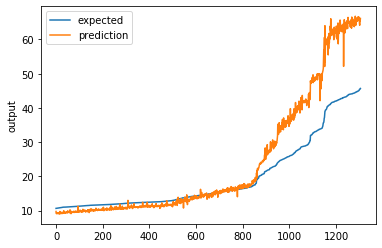

Score (RMSE): 8.83185177768922
Train on 3060 samples, validate on 1304 samples
Epoch 1/100
3060/3060 - 28s - loss: 1491.4644 - val_loss: 54.7598
Epoch 2/100
3060/3060 - 32s - loss: 172.6383 - val_loss: 77.0840
Epoch 3/100
3060/3060 - 23s - loss: 27.4250 - val_loss: 112.3129
Epoch 4/100
3060/3060 - 26s - loss: 15.6907 - val_loss: 76.2872
Epoch 5/100
3060/3060 - 18s - loss: 10.7101 - val_loss: 78.4620
Epoch 6/100
3060/3060 - 19s - loss: 8.0945 - val_loss: 88.9790
Epoch 00006: early stopping
Analyzing Model with 13 sequence length


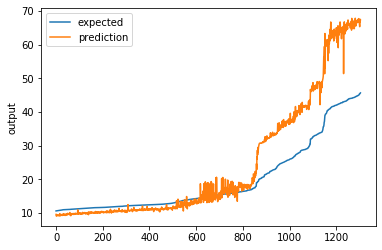

Score (RMSE): 9.432868850479721
Train on 3059 samples, validate on 1303 samples
Epoch 1/100
3059/3059 - 30s - loss: 1467.9150 - val_loss: 74.2836
Epoch 2/100
3059/3059 - 29s - loss: 192.6576 - val_loss: 48.9340
Epoch 3/100
3059/3059 - 36s - loss: 31.9803 - val_loss: 50.9566
Epoch 4/100
3059/3059 - 32s - loss: 17.4822 - val_loss: 103.1278
Epoch 5/100
3059/3059 - 25s - loss: 12.4580 - val_loss: 62.4778
Epoch 6/100
3059/3059 - 27s - loss: 8.5287 - val_loss: 91.9172
Epoch 7/100
3059/3059 - 23s - loss: 8.1480 - val_loss: 56.1494
Epoch 00007: early stopping
Analyzing Model with 14 sequence length


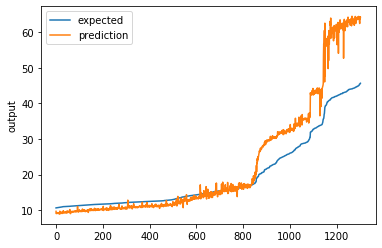

Score (RMSE): 7.493292956942669


In [15]:
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
split = int(0.35 * len(dt))
df_train = dt[:split]
df_train = df_train.append(dt[(len(dt) - split):len(dt)])
df_test = dt[split:(len(dt)-split)]

normal_list = ['Open', 'High', 'Low', 'Volume'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()

for x in range(5,15):
    SEQUENCE_SIZE = x
    x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
    obs_train = df_train['Close'][SEQUENCE_SIZE:len(df_train)].values.tolist()
    obs_train.pop()
    obs_train = np.asarray(obs_train)
    #print(obs_train.shape)
    
    x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
    obs_test = df_test['Close'][SEQUENCE_SIZE:len(df_test)].values.tolist()
    obs_test.pop()
    obs_test = np.asarray(obs_test)
    #print(obs_test.shape)
    
    
    myDict_seq = dict()
    iteration = x-5
    
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')        
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
    model.fit(x_train,obs_train,validation_data=(x_test,obs_test), callbacks=[monitor],verbose=2, epochs=100)  
    
    print("Analyzing Model with {} sequence length".format(x))
    pred_seq = model.predict(x_test)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred_seq,obs_test))
    chart_regression(pred_seq,obs_test)
    print("Score (RMSE): {}".format(score))
    
    myDict_seq.update({iteration : (model, x_test, obs_test)})

We see mixed results. The best model has a sequence of length 8, yet the second best has sequence of length 14. The results do not seem to follow any sort of pattern (we expected accuracy to improve with sequence length, but converge rather quickly).